In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw7.ipynb")

## Homework #7

*Please edit the cell below to add your name, NetID, and any group members that you collaborated with on this assignment.* **Complete this section before proceeding to the assignment questions.**

Name: Runze Li  
NetID: rl50xx  
Group Members: None   
***

In [2]:
# Set random seed and ensure plots are displayed in the notebook
import numpy as np
import arviz as az
np.random.seed(5)

%matplotlib inline

%config Inline.figure_format = 'retina'
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

In [3]:
# utility function for standardizing variables
def standardize(series):
    return (series - series.mean()) / series.std()

<!-- BEGIN QUESTION -->

**Question 1**. **(14 points)** Conduct a prior predictive simulation for the Reedfrog model. More specifically, simulate the prior distribution of tank survival probabilities $\alpha_j$. Start by using this prior:  

$\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma)$  
$\bar{\alpha} \sim \text{Normal}(0, 1)$  
$\sigma \sim \text{Exponential}(1)$  

**Be sure to transform the $\alpha_j$ values to the logistic/probability scale** for plotting and summarizing your results. 

Additionally, include prior predictive simulations with Exponential(10) and Exponential(0.1) prior distribution assignments for $\sigma$ to answer this question. 

*Note*: The parameterization of SciPy's exponential distribution uses $\frac{1}{\lambda}$ for the `scale` parameter. The $\lambda$ values to consider for this problem are [0.1,1,10] for the prior distributions of $\sigma$. You'll need to use the inverse of these values to specify the correct distribution if using `scipy.stats.expon.rvs()` for your prior predictive simulation.

In [4]:
# Write code here
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.special import expit as logistic

/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


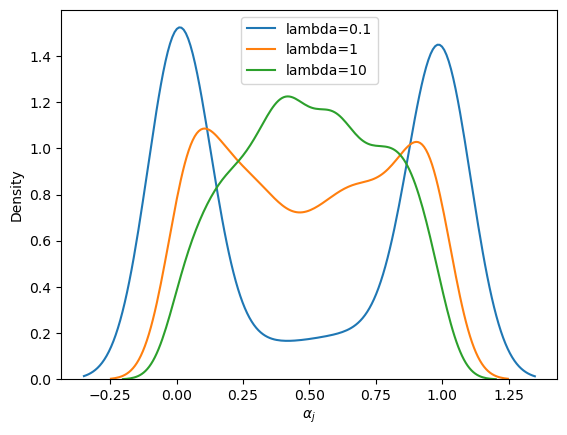

In [5]:
lambdas = [0.1, 1, 10]
comments = ["lambda=0.1", "lambda=1", "lambda=10"]

for i in range(len(lambdas)):
    sigma = stats.expon.rvs(1.0/lambdas[i], size=1000)
    a_bar = stats.norm.rvs(0, 1, size=1000)
    alphas = stats.norm.rvs(a_bar, sigma)
    alphas = logistic(alphas)
    sns.kdeplot(alphas, label=comments[i])

plt.xlabel(r"$\alpha_j$")
plt.legend()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

How does increasing the width of the prior on $\sigma$ change the prior distribution of $\alpha_j$? 

__Answer:__

When $\lambda$ is small, $\sigma$ becomes wider and $\alpha$ becomes more concave in the middle, which indicates that $\alpha$ is scattered on both sides. When $\lambda$ is large, $\sigma$ becomes narrower and $\alpha$ becomes less concave in the middle, which indicates that $\alpha$ is concentrated in the middle.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2**. **(20 points)** Revisit the Reedfrog survival data, _Data/reedfrogs.csv_. The causal model (in the form of a DAG) considered in lecture, is provided in the image below. 

![](tank_survival_dag.png)

Beginning with the varying effects model from lecture that estimates the causal effect of the treatment *predation* on *survival*, consider how tadpole **size** (`size`) might modify the effect of **predation** (`pred`). The model from lecture also included a parameter for the tank effect. Your model must also **include this parameter**.

*Note:* A straightforward approach is to estimate an effect for _**each combination**_ of *predation* and *size*. **Use a 2-dimensional categorical index parameter to estimate the effects of each combination.** 

**No plots are needed for full credit for any part of this question**. 

In [6]:
# Write code here
import pandas as pd
import pymc as pm

df = pd.read_csv("Data/reedfrogs.csv", sep=",")
pred = np.where(df.pred == "pred", 1, 0) # no - 0, pred - 1
n_pred = len(np.unique(pred))
size = np.where(df["size"] == "small", 0, 1) # small - 0, big - 1
n_size = len(np.unique(size))
# make the tank cluster variable
tank = np.arange(df.shape[0])
n_tanks = df.shape[0]

In [7]:
with pm.Model() as m_SPG:
    sigma = pm.Exponential("sigma", 1.0)

    a = pm.Normal("a", 0, sigma, shape=n_tanks)
    b = pm.Normal("b", 0, 1, shape=(n_pred, n_size))
    p = pm.math.invlogit(a[tank] + b[pred, size])

    S = pm.Binomial("S", n=df.density, p=p, observed=df.surv)
    idata_SPG = pm.sample(random_seed=8927)

az.summary(idata_SPG, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a, b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%
a[0],-0.015,0.632,-1.106,0.902
a[1],0.367,0.659,-0.701,1.363
a[2],-0.702,0.601,-1.676,0.221
a[3],0.364,0.680,-0.758,1.342
a[4],-0.007,0.630,-1.017,0.957
a[5],-0.001,0.596,-0.949,0.964
a[6],0.398,0.664,-0.702,1.409
a[7],0.007,0.613,-0.956,0.975
a[8],-0.000,0.525,-0.908,0.777
a[9],1.175,0.569,0.333,2.090


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Answer the following question**: What do the estimates of the parameters for the combinations of *predation* and *size* imply about the influence of these combinations on tadpole survival? 

__Answer:__

When predation and big size are both in the model, the combination of size and pred is negatively correlated with survival. In all other cases, the combination of size and pred is positively correlated with survival.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Now, approximate the posterior distribution of a **separate model** that considers the influence of the treatment variables individually (but within a single model). This __model will have distinct categorical index variables: one for *predation* and one for *size*__.  

In [8]:
with pm.Model() as m_SPG_1:
    sigma = pm.Exponential("sigma", 1.0)

    a = pm.Normal("a", 0, sigma, shape=n_tanks)
    bP = pm.Normal("bP", 0, 1, shape=(n_pred))
    bS = pm.Normal("bS", 0, 1, shape=(n_size))
    p = pm.math.invlogit(a[tank] + bP[pred] + bS[size])

    S = pm.Binomial("S", n=df.density, p=p, observed=df.surv)
    idata_SPG_1 = pm.sample(random_seed=8927)

az.summary(idata_SPG_1, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a, bP, bS]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 34 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%
a[0],0.005,0.654,-1.043,0.992
a[1],0.443,0.667,-0.644,1.478
a[2],-0.708,0.593,-1.589,0.286
a[3],0.445,0.683,-0.542,1.611
a[4],-0.136,0.668,-1.232,0.861
a[5],-0.141,0.664,-1.177,0.930
a[6],0.306,0.694,-0.872,1.361
a[7],-0.160,0.671,-1.310,0.827
a[8],-0.142,0.544,-1.055,0.659
a[9],1.125,0.599,0.173,2.037


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Answer the following question**: Is there any information gained from the model which uses the treatment combinations that would be missed if only measuring the influences of *predation* and *size* seperately? 

*Note: It may be helpful to convert the posterior estimates to the probability scale using a logistic transformation when interpreting the results.* 

__Answer:__

Size does not have much effect on survival, and all are positively correlated. However, the presence or absence of predation does have an effect on survival, and when predation is present, there is a negative correlation in the model with survival.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 3**. **(16 points)** Now consider the causal effect of tank _density_ (the original number of tadpoles in the tank) on *survival* and perform the following steps:

1. Recreate the model with distinct parameters for combinations of *predation* and *size* from Question 2 and add _density_ to your Binomial Generalized Linear Model (GLM) as a **standardized, continuous regression variable**.  
1. In this model, estimate a new, distinct parameter that measures the influence of density on survival **for each predation state**. This means the parameter that measures the influence of density on survival will be stratified by predation state. Be sure to **use the categorical index encoding approach** for this new parameter for full credit.   

In [9]:
# Write code here
density = standardize(df.density)

In [10]:
with pm.Model() as m_SPGD:
    sigma = pm.Exponential("sigma", 1.0)

    a = pm.Normal("a", 0, sigma, shape=(n_pred, n_size))
    b = pm.Normal("b", 0, 1, shape=(n_pred, n_size))
    p = pm.math.invlogit(a[pred, size] * density + b[pred, size])

    S = pm.Binomial("S", n=df.density, p=p, observed=df.surv)
    idata_SPGD = pm.sample(random_seed=8927)

az.summary(idata_SPGD, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a, b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%
"a[0, 0]",0.104,0.208,-0.203,0.441
"a[0, 1]",0.140,0.200,-0.174,0.459
"a[1, 0]",-0.164,0.135,-0.361,0.060
"a[1, 1]",-0.430,0.156,-0.685,-0.178
"b[0, 0]",2.340,0.225,1.960,2.655
"b[0, 1]",2.467,0.225,2.082,2.791
"b[1, 0]",0.403,0.137,0.187,0.624
"b[1, 1]",-0.393,0.138,-0.600,-0.162
sigma,0.397,0.234,0.119,0.690


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

3. Comment on whether *predation* modifies the effect of *density* by computing, plotting, **and interpreting** the contrast distribution for the effect of *predation*.  

__Answer:__   

The histogram shows two distinct peaks, with a concentration of posterior samples around the mean contrast value. The red area (no predation) has a peak to the left, while the blue area (predation) has a peak to the right. If more samples fall on the right side of zero, it implies that the majority of the posterior samples suggest an increase in density when predation is present. Based on this analysis, it can be concluded that predation modifies the density effect, generally leading to higher densities in predation scenarios compared to no predation. The contrast distribution suggests a significant effect of predation.

In [11]:
# Write code here
b_density_samples = idata_SPGD.posterior['b'].values
b_density_pred = b_density_samples[1, :].flatten()
b_density_no_pred = b_density_samples[0, :].flatten()
diff = b_density_pred - b_density_no_pred

/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: 

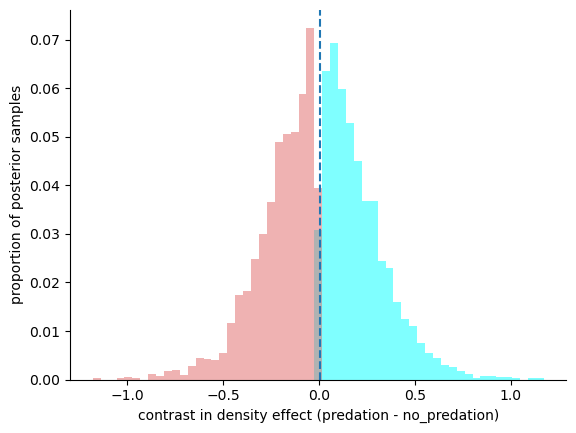

In [12]:
df_for_plot = pd.DataFrame({"diff": diff, "pos": np.where(diff > 0, 1, 0)})
ax = sns.histplot(data=df_for_plot, x="diff", hue="pos", stat="proportion", edgecolor=None, palette=["#e06666", "#00FFFF"], legend=None)
_ = ax.axvline(diff.mean(), linestyle="--")
_ = sns.despine(ax=ax, top=True, right=True)
_ = ax.set_xlabel("contrast in density effect (predation - no_predation)")
_ = ax.set_ylabel("proportion of posterior samples")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

4. Create a plot that includes the posterior distribution for $\sigma$ (the population-level tank standard deviation) in this model and the the posterior distribution for $\sigma$ from Question 2's predation/size combination model. This plot will include two separate distributions.

/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


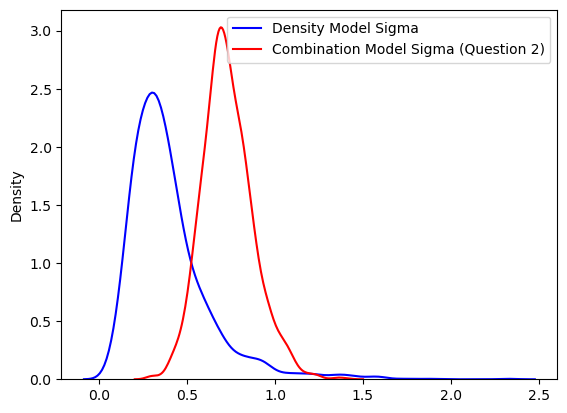

In [13]:
# Write code here
sigma_spgd_model = idata_SPGD.posterior.sigma.values.flatten()
sigma_spg_model = idata_SPG.posterior.sigma.values.flatten()

sns.kdeplot(sigma_spgd_model, color='b', label="Density Model Sigma")
sns.kdeplot(sigma_spg_model, color='r', label="Combination Model Sigma (Question 2)")
plt.legend()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

How are the distributions of the $\sigma$ parameters different? Why?

__Answer:__   

The $\sigma$ of the Combination Model (Question 2) is larger than the $\sigma$ of the Density Model, and its peak is higher, but the width of its curve is narrower than that of the density model.

In [14]:
grader.check("q3.3")

q3.3 results: All test cases passed!

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)